<a href="https://colab.research.google.com/github/jyothysankar14/full-adder-vlsi/blob/main/synthesizable_fulladder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install required packages (Icarus, Yosys, qflow + osu035 tech, magic, netgen)
!apt-get update -qq
!apt-get install -y -qq iverilog yosys qflow qflow-tech-osu035 graywolf qrouter magic netgen opensta


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# prepare workspace
import os, textwrap
os.makedirs("/content/fa_qflow", exist_ok=True)
os.chdir("/content/fa_qflow")

# write optimized full_adder.v
rtl = r"""
module full_adder(
    input wire A, B, Cin,
    output wire Sum, Cout
);
    // optimized form using shared XOR
    assign Sum  = A ^ B ^ Cin;
    assign Cout = (A & B) | (Cin & (A ^ B));
endmodule
"""
with open("full_adder.v","w") as f:
    f.write(textwrap.dedent(rtl).strip() + "\n")

# write tb_full_adder.v
tb = r"""
`timescale 1ns/1ps
module tb_full_adder;
    reg A, B, Cin;
    wire Sum, Cout;
    full_adder uut (.A(A), .B(B), .Cin(Cin), .Sum(Sum), .Cout(Cout));
    integer i;
    initial begin
        $display("A B Cin | Sum Cout");
        $display("------------------");
        for (i = 0; i < 8; i = i + 1) begin
            {A,B,Cin} = i[2:0];
            #1;
            $display("%b %b  %b  |  %b   %b", A, B, Cin, Sum, Cout);
        end
        $finish;
    end
    // vcd dump for waveform if desired
    initial begin
        $dumpfile("full_adder.vcd");
        $dumpvars(0, tb_full_adder);
    end
endmodule
"""
with open("tb_full_adder.v","w") as f:
    f.write(textwrap.dedent(tb).strip() + "\n")

print("Files created in /content/fa_qflow:")
print(os.listdir("."))


Files created in /content/fa_qflow:
['tb_full_adder.v', 'full_adder.v']


In [ ]:
# compile & run
!iverilog -g2012 -o sim_fulladder full_adder.v tb_full_adder.v
!vvp sim_fulladder


A B Cin | Sum Cout
------------------
VCD info: dumpfile full_adder.vcd opened for output.
0 0  0  |  0   0
0 0  1  |  1   0
0 1  0  |  1   0
0 1  1  |  0   1
1 0  0  |  1   0
1 0  1  |  0   1
1 1  0  |  0   1
1 1  1  |  1   1


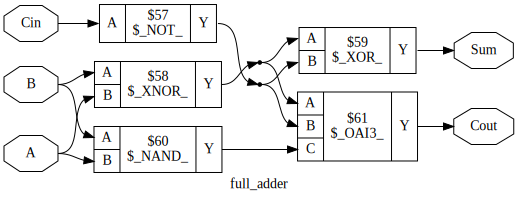

In [ ]:
from IPython.display import SVG, display
import os

svg_path = "synthesis/full_adder.svg"   # this is where yosys puts it when using that prefix

if os.path.exists(svg_path):
    display(SVG(svg_path))
else:
    # helpful debugging output if Yosys didn't create the file
    print(f"{svg_path} not found. Files in synthesis/:")
    print(os.listdir("synthesis"))
    # print yosys log if present
    if os.path.exists("yosys.log"):
        print("\n--- yosys.log ---")
        print(open("yosys.log").read())


In [ ]:
# qflow expects source in ./source — create and copy
!mkdir -p source
!cp full_adder.v source/
!ls -l


total 24
-rw-r--r-- 1 root root  199 Aug 13 14:42 full_adder.v
-rw-r--r-- 1 root root  648 Aug 13 14:43 full_adder.vcd
-rwxr-xr-x 1 root root 3540 Aug 13 14:43 sim_fulladder
drwxr-xr-x 2 root root 4096 Aug 13 14:56 source
drwxr-xr-x 2 root root 4096 Aug 13 14:46 synthesis
-rw-r--r-- 1 root root  611 Aug 13 14:42 tb_full_adder.v


In [ ]:
!qflow synthesize full_adder
!qflow place       full_adder
!qflow route       full_adder

# optional: run static timing analysis
!qflow sta full_adder

# produce display files (magic/def views)
!qflow display full_adder

# show produced layout folder and some artifacts
!echo "Layout dir:"
!ls -l layout || true
!echo "Synthesis dir:"
!ls -l synthesis || true
!echo "Log dir:"
!ls -l log || true



--------------------------------
Qflow project setup
--------------------------------

No technology specified or found;  using default technology osu035

Running yosys for verilog parsing and synthesis
yosys  -s full_adder.ys

 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2019  Clifford Wolf <clifford@clifford.at>           |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                 

In [ ]:
%%bash
# Use qflow-provided drc wrapper (calls Magic in batch with correct tech files)
if [ -x /usr/share/qflow/scripts/drc.sh ]; then
  /usr/share/qflow/scripts/drc.sh . full_adder osu035
else
  echo "drc.sh wrapper not found; attempting qflow drc (may vary by install)."
  qflow drc full_adder
fi

# Show the DRC log if produced
if [ -f log/drc_magic_full_adder.log ]; then
  echo "=== DRC log ==="
  sed -n '1,200p' log/drc_magic_full_adder.log
else
  echo "DRC log not found at log/drc_magic_full_adder.log"
  ls -l log || true
fi


drc.sh wrapper not found; attempting qflow drc (may vary by install).

--------------------------------
Qflow project setup
--------------------------------

Technology set to osu035 from existing qflow_vars.sh file
Regenerating files for existing project full_adder
Running magic 8.3.105
magic -dnull -noconsole  /content/fa_qflow/run_drc_full_adder.tcl

Magic 8.3 revision 105 - Compiled on Mon, 06 Dec 2021 22:32:27 +0200.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Input style lambda=0.20(p): scaleFactor=20, multiplier=1
Contact size value ignored (using GDS generation rules).
Contact size value ignored (using GDS generation rules).
Contact size value ignored (using GDS generation rules).
Contact size value ignored (using GDS generation rules).
Contact size value ignored (using GDS generation rules).
Contact size value ignored (using GDS generation rules).
4 Magic internal units = 1 Lambda
Loading "

In [ ]:
from google.colab import files
import os

# files to offer for download
candidates = [
  "full_adder.svg",
  "full_adder.v",
  "synthesis/full_adder_mapped.v",
  "layout/full_adder.def",
  "layout/full_adder.gds",
  "log/drc_magic_full_adder.log",
  "log/lvs_netgen_full_adder.log"
]

existing = [p for p in candidates if os.path.exists(p)]
print("Files available for download:", existing)

# zip available files
import zipfile
zipname = "fa_qflow_results.zip"
with zipfile.ZipFile(zipname, "w") as z:
    for p in existing:
        z.write(p)
print("Created", zipname)
files.download(zipname)


Files available for download: ['full_adder.v', 'synthesis/full_adder_mapped.v']
Created fa_qflow_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>